In [28]:
import sys
sys.argv = ['']

In [29]:
from diffuser.utils.arrays import to_torch, to_np, to_device
from diffuser.datasets.d4rl import suppress_output
from scripts.buffer_utils import LoadSequenceDataset
from scripts.buffer_utils import OptimalBuffer
from scripts.mopo.utils_trans import RewardPredictingModel 
from scripts.buffer_utils import augment_trajectories_new
import diffuser.utils as utils

In [30]:
import shutil 
import argparse 
import time 
import pickle
import sys
import os
import torch
import random
import importlib

In [31]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
from collections import defaultdict
import pdb

In [33]:
def import_config(config_name):
    module_path = f"detail_configs.{config_name}"
    try:
        module = importlib.import_module(module_path)
        return module.Config    
    except ImportError:
        print(f"Error: Module '{config_name}' not found or has no 'Config' attribute.")
        return None

In [34]:
from ml_logger import logger

Config = import_config('maze_large_flat_r3')

In [35]:
Config.dataset = 'PointMaze_Large-v3'

In [36]:
dataset_config = utils.Config(
		'datasets.CondSequenceDataset',
		savepath='dataset_config.pkl',
		env=Config.dataset,
		horizon=Config.horizon,
		normalizer=Config.normalizer,
		preprocess_fns=Config.preprocess_fns,
		use_padding=Config.use_padding,
		max_path_length=Config.max_path_length,
		include_returns=Config.include_returns,
		returns_scale=Config.returns_scale,
        data_file=Config.data_file,
        stitch=Config.stitch,
        task_data=Config.task_data,
        jump=Config.jump,
        aug_data_file=Config.aug_data_file
	)
render_config = utils.Config(
        Config.renderer,
        savepath="render_config.pkl",
        env=Config.dataset,
    )

dataset = dataset_config()
renderer = render_config()
observation_dim = dataset.observation_dim
action_dim = dataset.action_dim
loadpath = os.path.join(Config.bucket, Config.dataset, Config.prefix, 'checkpoint')
print('\n\nloadpath = ', loadpath, end = '\n\n')  

[ utils/config ] Imported diffuser.datasets:CondSequenceDataset

[utils/config ] Config: <class 'diffuser.datasets.sequence.CondSequenceDataset'>
    aug_data_file: /common/users/cc1547/dataset/rainbow/stitching_maze/round3_pointmaze_large_H80-v1.pkl
    data_file: /common/users/cc1547/dataset/rainbow/stitching_maze/
    env: PointMaze_Large-v3
    horizon: 320
    include_returns: False
    jump: 1
    max_path_length: 1000
    normalizer: LimitsNormalizer
    preprocess_fns: []
    returns_scale: 400.0
    stitch: True
    task_data: False
    use_padding: False

[ utils/config ] Saved config to: dataset_config.pkl

[ utils/config ] Imported diffuser.utils:Maze2dRenderer

[utils/config ] Config: <class 'diffuser.utils.rendering.Maze2dRenderer'>
    env: PointMaze_Large-v3

[ utils/config ] Saved config to: render_config.pkl

class =  <class 'diffuser.datasets.sequence.CondSequenceDataset'>
kwargs =  {}
[ datasets/buffer ] Finalized replay buffer | 4226 episodes
[ datasets/buffer ] Fi

In [37]:
loadpath = os.path.join(loadpath, f'state_800000.pt')
state_dict = torch.load(loadpath, map_location=Config.device)

observation_dim = dataset.observation_dim
action_dim = dataset.action_dim
transition_dim = observation_dim

model_config = utils.Config(
		Config.model,
		savepath='model_config.pkl',
		horizon=Config.horizon,
		transition_dim=transition_dim,
		cond_dim=observation_dim,
		dim_mults=Config.dim_mults,
		dim=Config.dim,
		returns_condition=Config.returns_condition,
		device=Config.device,
	)

diffusion_config = utils.Config(
    Config.diffusion,
    savepath='diffusion_config.pkl',
    horizon=Config.horizon,
    observation_dim=observation_dim,
    action_dim=action_dim,
    n_timesteps=Config.n_diffusion_steps,
    loss_type=Config.loss_type,
    clip_denoised=Config.clip_denoised,
    predict_epsilon=Config.predict_epsilon,
    hidden_dim=Config.hidden_dim,
    ## loss weighting
    action_weight=Config.action_weight,
    loss_weights=Config.loss_weights,
    loss_discount=Config.loss_discount,
    returns_condition=Config.returns_condition,
    device=Config.device,
    condition_guidance_w=Config.condition_guidance_w,
)

trainer_config = utils.Config(
		utils.Trainer,
		savepath='trainer_config.pkl',
		train_batch_size=Config.batch_size,
		train_lr=Config.learning_rate,
		gradient_accumulate_every=Config.gradient_accumulate_every,
		ema_decay=Config.ema_decay,
		sample_freq=Config.sample_freq,
		save_freq=Config.save_freq,
		log_freq=Config.log_freq,
		label_freq=int(Config.n_train_steps // Config.n_saves),
		save_parallel=Config.save_parallel,
		bucket=Config.bucket,
		n_reference=Config.n_reference,
        n_samples=Config.n_samples,
		train_device=Config.device,
	)
model = model_config()
diffusion = diffusion_config(model)
trainer = trainer_config(diffusion, dataset, renderer)
# logger.print(utils.report_parameters(model), color='green')
trainer.step = state_dict['step']
trainer.model.load_state_dict(state_dict['model'])
trainer.ema_model.load_state_dict(state_dict['ema'])

[ utils/config ] Imported diffuser.models:TemporalUnet

[utils/config ] Config: <class 'diffuser.models.temporal.TemporalUnet'>
    cond_dim: 4
    dim: 128
    dim_mults: (1, 4, 8)
    horizon: 320
    returns_condition: False
    transition_dim: 4

[ utils/config ] Saved config to: model_config.pkl

[ utils/config ] Imported diffuser.models:GaussianInvDynDiffusion

[utils/config ] Config: <class 'diffuser.models.diffusion.GaussianInvDynDiffusion'>
    action_dim: 2
    action_weight: 10
    clip_denoised: False
    condition_guidance_w: 1.2
    hidden_dim: 256
    horizon: 320
    loss_discount: 1
    loss_type: l2
    loss_weights: None
    n_timesteps: 256
    observation_dim: 4
    predict_epsilon: False
    returns_condition: False

[ utils/config ] Saved config to: diffusion_config.pkl


[utils/config ] Config: <class 'diffuser.utils.training.Trainer'>
    bucket: /common/users/cc1547/projects/rainbow/diffstitch/diffuser/
    ema_decay: 0.995
    gradient_accumulate_every: 2
   

<All keys matched successfully>

In [51]:
inv_model_state_dict_path = '/common/users/cc1547/projects/rainbow/diffstitch/diffuser/maze/flat_round3/inv_only/PointMaze_Large-v3/' \
    'default_inv/predict_epsilon_100_1000000.0/dropout_0.25/maze/flat_round3/inv_only/checkpoint/state_900000.pt'
inv_model_state_dict = torch.load(inv_model_state_dict_path, map_location=Config.device)
 
inv_model_state = {}
inv_model_state_ema = {}
for k in inv_model_state_dict['model']:
    if 'inv_model' in k:
        new_k = k.split('.', 1)[-1]
        inv_model_state[new_k] = inv_model_state_dict['model'][k]
        inv_model_state_ema[new_k] = inv_model_state_dict['ema'][k]
trainer.model.inv_model.load_state_dict(inv_model_state)
trainer.ema_model.inv_model.load_state_dict(inv_model_state_ema)

<All keys matched successfully>

In [52]:
def get_test_start_state_goals(dataset_name):
    if dataset_name in ["PointMaze_Medium-v3"]:
        test_start_state_goal = [
            {
                "goal_cell": np.array([1, 1], dtype=np.int32),
                "reset_cell": np.array([6, 6], dtype=np.int32),
                "name": "top_left_to_bottom_right",
            },
            {
                "goal_cell": np.array([1, 6], dtype=np.int32),
                "reset_cell": np.array([6, 1], dtype=np.int32),
                "name": "bottom_left_to_top_right",
            },
        ]
    elif dataset_name in ["PointMaze_Large-v3"]:
        test_start_state_goal = [
            {
                "goal_cell": np.array([7, 2], dtype=np.int32),
                "reset_cell": np.array([1, 4], dtype=np.int32),
                "name": "top_left_to_bottom_right",
            },
            {
                "goal_cell": np.array([7, 5], dtype=np.int32),
                "reset_cell": np.array([1, 6], dtype=np.int32),
                "name": "bottom_left_to_top_right",
            },
            {
                "goal_cell": np.array([7, 10], dtype=np.int32),
                "reset_cell": np.array([1, 1], dtype=np.int32),
                "name": "bottom_left_to_top_right",
            },
        ]
    else:
        raise NotImplementedError

    return test_start_state_goal

In [53]:
def cell_xy_to_rowcol(maze, xy_pos: np.ndarray) -> np.ndarray:
    """Converts a cell x and y coordinates to `(i,j)`"""

    i = np.reshape((maze.y_map_center - xy_pos[:, 1]) / maze.maze_size_scaling, (-1, 1))
    j = np.reshape((xy_pos[:, 0] + maze.x_map_center) / maze.maze_size_scaling, (-1, 1))

    return np.concatenate([i,j], axis=-1)

In [62]:
test_start_state_goal = get_test_start_state_goals(Config.dataset)
sg = test_start_state_goal[1]

In [63]:
horizon = Config.horizon
device = Config.device
dynamics_deviate = 0.5
test_ret = Config.test_ret
sample_optim_batch = 1000
dreamer_similarity = 1.5
stitch_L = 30
stitch_R = 60
obs_dim = observation_dim
dream_len = Config.dream_len
stitch_batch_size = 400

In [64]:
num_eval = 30

In [65]:
horizon

320

In [68]:
total_rewards = []
returns = None

env_list = [gym.make(Config.dataset, continuing_task=False) for _ in range(num_eval)]
dones = [False for _ in range(num_eval)]
episode_rewards = [0 for _ in range(num_eval)]

obs_ = [env.reset(options=sg)[0] for env in env_list]
obs_list = [obs['observation'][None] for obs in obs_]
obs = np.stack(obs_list, axis=0)

target_list = [np.array(list(obs['desired_goal']) + [0.0] * 2)[None] for obs in obs_]
target = np.stack(target_list, axis=0)
target_normed = dataset.normalizer.normalize(target, 'observations')

t = 0
max_step = env_list[0].spec.max_episode_steps
rollout = defaultdict(list)
while (sum(dones) < num_eval) and (t < max_step):
    
    state_normed = dataset.normalizer.normalize(obs, 'observations')
    
    cond = np.ones(shape=(num_eval, horizon, 2 * obs_dim))
    cond[:, :, obs_dim:] = 0
    cond[:, :1, :obs_dim] = 0
    cond[:, :1, obs_dim:] = state_normed
    
    for i in range(num_eval):
        goal = target[i, 0,:2]
        xy = obs[i, 0, :2]
        target_goal_dist = np.linalg.norm(xy - goal)
        if target_goal_dist > 5.6:
            cond[i, -1:, :obs_dim] = 0
            cond[i, -1:, obs_dim:] = target_normed[i]
        elif target_goal_dist > 4.4:
            cond[i, -3*16:, :obs_dim] = 0
            cond[i, -3*16:, obs_dim:] = target_normed[i]

        elif target_goal_dist > 3.6:
            cond[i, -5*16:, :obs_dim] = 0
            cond[i, -5*16:, obs_dim:] = target_normed[i]
        elif target_goal_dist > 2.8:
            cond[i, -7*16:, :obs_dim] = 0
            cond[i, -7*16:, obs_dim:] = target_normed[i]
        elif target_goal_dist > 2.:
            cond[i, -9*16:, :obs_dim] = 0
            cond[i, -9*16:, obs_dim:] = target_normed[i]
        elif target_goal_dist > 1.2:
            cond[i, -11*16:, :obs_dim] = 0
            cond[i, -11*16:, obs_dim:] = target_normed[i]
        elif target_goal_dist > 0.6:
            cond[i, -15*16:, :obs_dim] = 0
            cond[i, -15*16:, obs_dim:] = target_normed[i]
        else:
            cond[i, -19*16:, :obs_dim] = 0
            cond[i, -19*16:, obs_dim:] = target_normed[i]
            
    
    cond[:, -1:, :obs_dim] = 0
    cond[:, -1:, obs_dim:] = target_normed
    conditions = torch.tensor(cond).to(device)
    returns = to_device(test_ret * torch.ones(stitch_batch_size, 1), device)
    
    samples = trainer.ema_model.conditional_sample(
        conditions, returns=returns, verbose=False
    )  # shape is [1, 100, 11]
    obs_comb = torch.cat([samples[:, 0, :], samples[:, 1, :]], dim=-1)
    obs_comb = obs_comb.reshape(-1, 2*observation_dim)
    action = trainer.ema_model.inv_model(obs_comb)
    action = to_np(action)

    action = dataset.normalizer.unnormalize(action, 'actions')
    action = np.clip(action, -1, 1)

    obs_list = []
    for i in range(num_eval):
        rollout[i].append(obs[i, 0])
        this_obs, this_reward, this_done, _, _ = env_list[i].step(action[i])
        obs_list.append(this_obs['observation'][None])
        moved = np.linalg.norm(obs_list[i][0, :2] - obs[i, 0, :2])
        print(f' ==========  Agent {i} moved: {moved} ==============')

        goal = target[i, 0,:2]
        xy = obs[i, 0, :2]
        target_goal_dist = np.linalg.norm(xy - goal)
        print(
            f'Agent {i} t: {t} | pos: {xy} | goal: {goal} |  target_goal_dist: {target_goal_dist:.2f})'
        )
        if target_goal_dist <= 0.5:
            this_done = True
        if not dones[i]:
            episode_rewards[i] += this_reward

            if this_done:
                dones[i] = 1
                logger.print(f"Episode ({i}): {episode_rewards[i]}", color="green")

    obs = np.stack(obs_list, axis=0)
    t += 1

episode_rewards = np.array(episode_rewards)
total_rewards.append(episode_rewards)

logger.print(
    f"average_ep_reward: {np.mean(episode_rewards)}, std_ep_reward: {np.std(episode_rewards)}",
    color="green",
)
logger.log_metrics_summary(
    {
        "average_ep_reward": np.mean(episode_rewards),
        "std_ep_reward": np.std(episode_rewards),
    }
)

[env.close() for env in env_list]

# rollout = np.array(rollout)
# maze_map = np.array(eval_env.unwrapped.maze._maze_map)
# maze = eval_env.unwrapped.maze
# _background = maze_map == 1

# plt.imshow(
#         _background * 0.5,
#         cmap=plt.cm.binary,
#         vmin=0,
#         vmax=1,
#         )
# obs_ij = cell_xy_to_rowcol(maze, rollout) - 0.5
# path_length = obs_ij.shape[0]
# colors = plt.cm.Greens(np.linspace(0.2, 1, path_length))
# plt.scatter(obs_ij[:,1], obs_ij[:,0], s=4, c=colors)
# plt.axis('off')
# plt.title('Actual Rollouts')
# plt.show() 
    

 ==========  Agent 0 moved: 0.0014051457748238518 ==============
Agent 0 t: 0 | pos: [0.29971433 3.18655945] | goal: [-0.4307951  -3.12374374] |  target_goal_dist: 6.35)
 ==========  Agent 1 moved: 0.002483466358554194 ==============
Agent 1 t: 0 | pos: [0.6507674  2.79716589] | goal: [-0.61083697 -3.20124349] |  target_goal_dist: 6.13)
 ==========  Agent 2 moved: 0.0018504051743015943 ==============
Agent 2 t: 0 | pos: [0.46781535 2.80374513] | goal: [-0.57052783 -3.22875541] |  target_goal_dist: 6.12)
 ==========  Agent 3 moved: 0.0016532727500234551 ==============
Agent 3 t: 0 | pos: [0.55534615 2.77848837] | goal: [-0.45326226 -2.76768186] |  target_goal_dist: 5.64)
 ==========  Agent 4 moved: 0.0027769889545894415 ==============
Agent 4 t: 0 | pos: [0.62458934 3.00510775] | goal: [-0.74959971 -2.98148438] |  target_goal_dist: 6.14)
 ==========  Agent 5 moved: 0.0020471981973031895 ==============
Agent 5 t: 0 | pos: [0.66312614 2.82139991] | goal: [-0.61829154 -2.9949627 ] |  targe

KeyboardInterrupt: 

In [69]:
np.array(dones).sum()

0

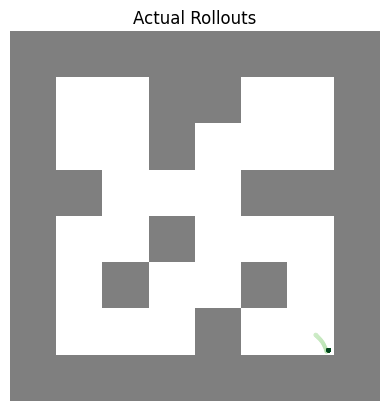

In [19]:

rollout = np.array(rollout)

maze_map = np.array(eval_env.unwrapped.maze._maze_map)
maze = eval_env.unwrapped.maze
_background = maze_map == 1
plt.imshow(
        _background * 0.5,
        cmap=plt.cm.binary,
        vmin=0,
        vmax=1,
        )
obs_ij = cell_xy_to_rowcol(maze, rollout) - 0.5
path_length = obs_ij.shape[0]
colors = plt.cm.Greens(np.linspace(0.2, 1, path_length))
plt.scatter(obs_ij[:,1], obs_ij[:,0], s=4, c=colors)
plt.axis('off')
plt.title('Actual Rollouts')
plt.show()

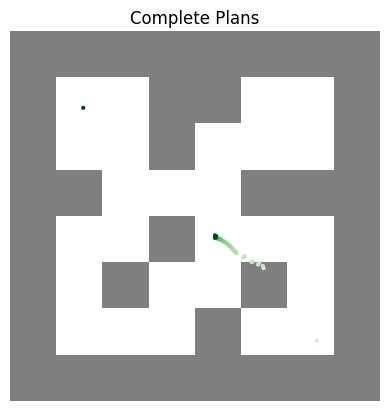

In [23]:
maze_map = np.array(eval_env.unwrapped.maze._maze_map)
maze = eval_env.unwrapped.maze
_background = maze_map == 1

plt.imshow(
    _background * 0.5,
    cmap=plt.cm.binary,
    vmin=0,
    vmax=1,
    )
obs_ij = cell_xy_to_rowcol(maze, np_samples[0]) - 0.5
path_length = obs_ij.shape[0]
colors = plt.cm.Greens(np.linspace(0.2, 1, path_length))
plt.scatter(obs_ij[:,1], obs_ij[:,0], s=4, c=colors)
plt.axis('off')
plt.title('Complete Plans')
plt.show()